In [6]:
#imports
from qiskit import IBMQ, Aer, assemble, transpile, QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.visualization import array_to_latex
from qiskit.tools.monitor import job_monitor 
from qiskit import *
from qiskit.visualization import *
from qiskit.visualization import plot_histogram
from qiskit.providers.ibmq import RunnerResult

import numpy as np
from numpy import sum
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from math import pi

In [7]:
# where can we use qiskit runtime 
provider = IBMQ.load_account()
runtime_backends = provider.backends(input_allowed='runtime')
print(runtime_backends)

ibmqfactory.load_account:WARNING:2022-03-10 04:17:00,594: Credentials are already in use. The existing account in the session will be replaced.


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_manila') fro

In [8]:
#loading account
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-education', group='fermilab-1', project='qjs-for-hep')
backend = provider.get_backend('ibmq_belem')
program = provider.runtime.program('circuit-runner')

ibmqfactory.load_account:WARNING:2022-03-10 04:17:06,939: Credentials are already in use. The existing account in the session will be replaced.


In [9]:
#sim code clement sent (thanks clement)
N = 2
epsilon = 0.5
mass = 1.0
nqubits = 3

def gauge_kinetic(epsilon):
    circuit=QuantumCircuit(1)
    circuit.rx(-epsilon/2,0)
    U_kg = circuit.to_gate()
    U_kg.name = "U$_{Kg}$"
    return U_kg

def fermion_mass(epsilon,mass,eta):
    circuit=QuantumCircuit(1)
    circuit.rz(-epsilon*mass * eta,0)
    U_m = circuit.to_gate()
    U_m.name = "U$_m$"
    return U_m

def fermion_hopping_opt2(epsilon,eta):
    circuit= QuantumCircuit(3)
    circuit.cx(0,2)
    circuit.h(0)
    circuit.cx(1,0)
    circuit.cx(0,2)
    circuit.rz(epsilon/4 * eta,0)
    circuit.rz(-epsilon/4 * eta,2)
    circuit.cx(0,2)
    circuit.cx(1,0)
    circuit.h(0)
    circuit.cx(0,2)
    U_fho2 = circuit.to_gate()
    U_fho2.name = "U$_{fho2}$"
    return U_fho2

#mean fermion number function for noisy counts 
def get_mean_fermion_number(counts):
    mean = 0
    values= list(counts.values())
    total_counts = sum(values)
    for s in counts:
        p = s[-1]
        if p == '1':
             mean = mean + (counts[s]/total_counts)
    return mean

#mean fermion number function for mitigated counts 
def get_mean_fermion_number2(counts):
    mean = 0
    for s in counts:
        p = s[-1]
        if p == '1':
            mean = mean + counts[s]
    return mean

#bootstrap error function for noisy counts
def get_bootstrap_error(counts):
    values= list(counts.values())
    nshots=sum(values)
    B = 100
    k = list(counts.keys())
    prob = [counts[a]/nshots for a in k]
    means = []
    for b in range(B):
        m = 0
        samples = np.random.choice(k, size=nshots, p=prob)
        for s in samples:
            p = s[-1]
            if p == '1':
                m = m + (1/nshots)
        means.append(m)
    return np.std(means), nshots

#bootstrap error function for mitigated counts 
def get_bootstrap_error2(counts, nshots):
    values= list(counts.values())
    B = 100
    k = list(counts.keys())
    means = []
    for b in range(B):
        m = 0
        samples = np.random.choice(k, size=nshots, p=values)
        for s in samples:
            p = s[-1]
            if p == '1':
                m = m + (1/nshots)
        means.append(m)
    return np.std(means)

counts=[]
counts2=[]
noisymeans = []
mitigatedmeans = []
noisyerrs= []
mitigatederrs = []
Ts=[]

for T in range(int(0/epsilon),int(3/epsilon)):
    Ts.append(T)
    qc = QuantumCircuit(2*N-1, 2*N-1)

    qc.x(0)
    qc.h(0)

    for t in range(T):
        for n in range(0,2*N,2):
            qc.append(fermion_mass(epsilon,mass,(-1)**(n/2+1)),[n])
        for l in range(1,2*N-1,2):
            qc.append(gauge_kinetic(epsilon),[l])
        for n in range(0,2*N-3,2):
            qc.append(fermion_hopping_opt2(epsilon, (-1)**(n/2)),[n,n+1,n+2])
    
    #creating the circut and running it using qiskit runtime 
    qc.measure(range(3), range(3))
    
    program_inputs = {
    'circuits': qc,
    'optimization_level': 3,
    'measurement_error_mitigation': True
    }
    options = {'backend_name': backend.name()}
    job = provider.runtime.run(program_id="circuit-runner",
                               options=options,
                               inputs=program_inputs,
                              )
    
    #appending noisy dictionary to counts
    result = job.result(decoder=RunnerResult)
    noisy = result.get_counts()
    counts.append(noisy)
    
    #appending mitigated diction to counts2 making sure to change the keys into states
    mitigated = result.get_quasiprobabilities().nearest_probability_distribution()
    dict2 = {}
    for key1 in mitigated:
        key2 = (bin(key1)[2:]).zfill(nqubits)
        dict2[key2] = mitigated[key1]
    counts2.append(dict2)
    
    #getting errs + mean fermion number 
    noisymeans.append(get_mean_fermion_number(counts[T]))  
    mitigatedmeans.append(get_mean_fermion_number2(counts2[T]))
    
    #getting bootstrap error for both noisy and mitigated results 
    #the get bootstrap error function returns nshots as well so that the second getbootstraperror function can take it in as an argument and doesn't have to calculate it 
    bootstrap_error = get_bootstrap_error(counts[T])
    noisyerrs.append(bootstrap_error[0])
    nshots = bootstrap_error[1]
    mitigatederrs.append(get_bootstrap_error2(counts2[T], nshots))  

In [10]:
print(counts)
print(counts2)
print(noisymeans)
print(mitigatedmeans)
print(noisyerrs)
print(mitigatederrs)

[{'000': 2045, '001': 1906, '010': 15, '011': 14, '100': 9, '101': 11}, {'000': 1817, '001': 1662, '010': 87, '011': 79, '100': 171, '101': 176, '110': 3, '111': 5}, {'000': 1737, '001': 1279, '010': 104, '011': 86, '100': 488, '101': 280, '110': 14, '111': 12}, {'000': 1472, '001': 1117, '010': 403, '011': 203, '100': 322, '101': 382, '110': 50, '111': 51}, {'000': 1391, '001': 946, '010': 429, '011': 307, '100': 436, '101': 334, '110': 59, '111': 98}, {'000': 1172, '001': 707, '010': 687, '011': 306, '100': 481, '101': 403, '110': 118, '111': 126}]
[{'000': 0.49852982856094913, '001': 0.5014701714390508}, {'110': 0.00031179056529451334, '111': 0.0009310557383994584, '011': 0.018128754519010082, '010': 0.018689005237901988, '100': 0.03993979166181011, '101': 0.04475595484467913, '001': 0.43411892157046206, '000': 0.4431247258624426}, {'110': 0.002414963316558525, '111': 0.0025920156585806284, '011': 0.020972096741127648, '010': 0.023414021680632967, '101': 0.07274749061467371, '100': 

In [11]:
counts = [{'000': 2045, '001': 1906, '010': 15, '011': 14, '100': 9, '101': 11}, {'000': 1817, '001': 1662, '010': 87, '011': 79, '100': 171, '101': 176, '110': 3, '111': 5}, {'000': 1737, '001': 1279, '010': 104, '011': 86, '100': 488, '101': 280, '110': 14, '111': 12}, {'000': 1472, '001': 1117, '010': 403, '011': 203, '100': 322, '101': 382, '110': 50, '111': 51}, {'000': 1391, '001': 946, '010': 429, '011': 307, '100': 436, '101': 334, '110': 59, '111': 98}, {'000': 1172, '001': 707, '010': 687, '011': 306, '100': 481, '101': 403, '110': 118, '111': 126}]
counts2 = [{'000': 0.49852982856094913, '001': 0.5014701714390508}, {'110': 0.00031179056529451334, '111': 0.0009310557383994584, '011': 0.018128754519010082, '010': 0.018689005237901988, '100': 0.03993979166181011, '101': 0.04475595484467913, '001': 0.43411892157046206, '000': 0.4431247258624426}, {'110': 0.002414963316558525, '111': 0.0025920156585806284, '011': 0.020972096741127648, '010': 0.023414021680632967, '101': 0.07274749061467371, '100': 0.12256237603595721, '001': 0.33098471796201484, '000': 0.4243123179904545}, {'110': 0.011110424538475206, '111': 0.01253493336386689, '011': 0.05085671993295462, '100': 0.07711290974867994, '010': 0.09987785352372397, '101': 0.10082781126778344, '001': 0.28848631078782805, '000': 0.35919303683668785}, {'110': 0.013319650934723731, '111': 0.026052645233454637, '011': 0.07887625829766605, '101': 0.08782394805979152, '010': 0.10597842834058921, '100': 0.1093789347696435, '001': 0.2401114418740323, '000': 0.3384586924900989}, {'110': 0.027839514413014688, '111': 0.03372890144656247, '011': 0.07977021222947046, '101': 0.10689169129617024, '100': 0.11883212932647443, '010': 0.17463764058348133, '001': 0.17838155560303356, '000': 0.2799183551017928}]
noisymeans = [0.48274999999999996, 0.4804999999999999, 0.41425, 0.43825, 0.42125, 0.38549999999999995]
mitigatedmeans = [0.5014701714390508, 0.4979346866725507, 0.4272963209763968, 0.452705775352433, 0.4328642934649445, 0.39877236057523674]
noisyerrs = [0.007323334281595249, 0.007045940320495843, 0.00827513557290664, 0.007570247684190219, 0.007999988671866099, 0.006580867628967357]
mitigatederrs = [0.008166794046624765, 0.007910722154139061, 0.006773095211938918, 0.007214351582088895, 0.007662755297540635, 0.007872665923941289]

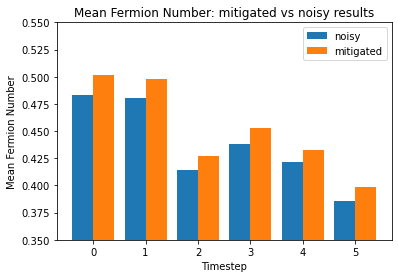

In [14]:
X = ['0','1','2','3', '4', '5']
X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, noisymeans, 0.4, label = 'noisy')
plt.bar(X_axis + 0.2, mitigatedmeans, 0.4, label = 'mitigated')

  
plt.xticks(X_axis, X)
plt.xlabel("Timestep")
plt.ylabel("Mean Fermion Number")
plt.title("Mean Fermion Number: mitigated vs noisy results")
plt.ylim([0.35, 0.55])
plt.legend()
plt.show()

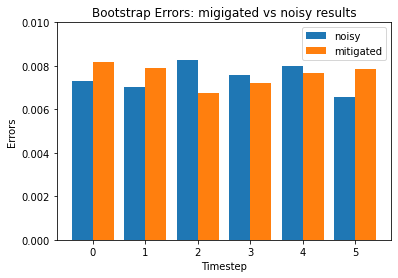

In [18]:
X = ['0','1','2','3', '4', '5']
X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, noisyerrs, 0.4, label = 'noisy')
plt.bar(X_axis + 0.2, mitigatederrs, 0.4, label = 'mitigated')

  
plt.xticks(X_axis, X)
plt.xlabel("Timestep")
plt.ylabel("Errors")
plt.title("Bootstrap Errors: migigated vs noisy results")
plt.ylim([0.00, 0.01])
plt.legend()
plt.show()

<ErrorbarContainer object of 3 artists>

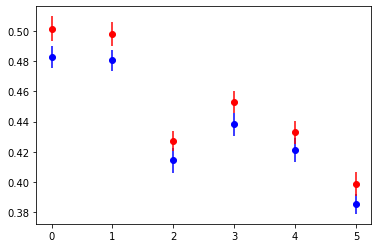

In [19]:
plt.errorbar(Ts, noisymeans , yerr=noisyerrs, ls='', marker='o', color='b')
plt.errorbar(Ts, mitigatedmeans , yerr=mitigatederrs, ls='', marker='o', color='r')